In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from glob import glob
from pathlib import Path, PurePath, PurePosixPath

image_files = glob("glyco/*_DAPI*")

def cellcount(img):
    # plt.figure()
    # plt.imshow(img)
    # plt.show()
    th, img_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    minimum_area = 400
    average_cell_area = 1600
    connected_cell_area = 6400
    cells = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if area > minimum_area:
            # cv2.drawContours(img, [c], -1, (255,255,255), 2)
            if area > connected_cell_area:
                cells += math.ceil(area / average_cell_area)
            else:
                cells += 1
    # plt.figure()
    # plt.imshow(close)
    # plt.imshow(img)
    # plt.show()
    return cells



In [2]:
import scipy.ndimage as im
import scipy.signal as sig

def gaussian_mask(sz=3, sigma=1/np.sqrt(2)):
    output = np.zeros([sz, sz])
    for i in range(sz):
        for j in range(sz):
            output[i,j] = np.exp(-0.5 * ((i - (sz - 1)/2)**2 + (j - (sz-1)/2)**2) / sigma ** 2)
    return output / np.sum(output)

def unsharp_mask(im, a, sz, sigma):
    S = im - sig.convolve2d(im, gaussian_mask(sz, sigma), "same")
    sharpened = im + a * S
    return np.min(np.array([np.max(np.array([sharpened, np.zeros_like(sharpened)]), axis=0), np.ones_like(sharpened) * 255]), axis=0)

def median_filter(image, sz=3):
    '''
    Applies median filter of size 3x3 without padding
    '''
    im_stacked = np.zeros([image.shape[0] - (sz-1), image.shape[1] - (sz - 1), sz**2])
    count = 0
    for n in range(sz):
        for m in range(sz):
            im_stacked[:,:,count] = image[0+n:image.shape[0] - (sz - 1) + n, 0+m:image.shape[1]-(sz-1) + m]
            count += 1
    output_im = np.median(im_stacked, axis=2)
    return output_im

In [64]:
cell_counts = {}
conditions = [50, 75, 100, 150, 200, 250, "Untreated", "+ EtOH", "+ Fluorophore"]

for im_file in image_files:
    key = Path(im_file).name[0:2]

    dapi = cv2.imread(im_file, cv2.IMREAD_GRAYSCALE)
    dapi = median_filter(dapi)

    dapi = np.max(np.stack([dapi, np.zeros_like(dapi)], axis=0), axis=0).astype(np.uint8)
    dapi1 = dapi[0:767, 0:1023]
    dapi2 = dapi[0:767, 1023:]
    dapi3 = dapi[767:, 0:1023]
    dapi4 = dapi[767:, 1023:]

    cells1 = cellcount(dapi1)
    cells2 = cellcount(dapi2)
    cells3 = cellcount(dapi3)
    cells4 = cellcount(dapi4)
    cell_counts[key] = {"0":cells1, "1":cells2, "2":cells3, "3":cells4}

cell_counts = pd.DataFrame().from_dict(cell_counts)
cell_counts.to_csv("thing.csv")
cell_counts = cell_counts / cell_counts["D1"].mean()
cell_counts.columns = conditions
cell_counts

,50,75,100,150,200,250,Untreated,+ EtOH,+ Fluorophore
0,1.552239,0.119403,0.358209,0.567164,0.567164,0.298507,1.074627,1.014925,0.477612
1,1.253731,0.328358,0.179104,0.597015,0.208955,0.656716,1.313433,1.074627,0.447761
2,1.134328,0.328358,0.208955,0.686567,0.268657,0.447761,0.895522,0.985075,0.208955
3,1.044776,0.119403,0.119403,0.805970,0.208955,0.507463,0.716418,1.373134,0.447761


In [93]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

stats_dict = {}
for cond in conditions:
    cond_dict = {}
    for cond2 in conditions:
        if cond == cond2:
            cond_dict[cond2] = np.NaN
        else:

            res = mannwhitneyu(cell_counts[cond], cell_counts[cond2], nan_policy="omit")
            cond_dict[cond2] = res.pvalue
    stats_dict[cond] = cond_dict
stats_df = pd.DataFrame().from_dict(stats_dict)
stats_df < 0.05

,50,75,100,150,200,250,Untreated,+ EtOH,+ Fluorophore
50,False,True,True,True,True,True,False,False,True
75,True,False,False,True,False,False,True,True,False
100,True,False,False,True,False,False,True,True,False
150,True,True,True,False,True,False,False,True,True
200,True,False,False,True,False,False,True,True,False
250,True,False,False,False,False,False,True,True,False
Untreated,False,True,True,False,True,True,False,False,True
+ EtOH,False,True,True,True,True,True,False,False,True
+ Fluorophore,True,False,False,True,False,False,True,True,False


In [94]:
selected = cell_counts.copy()
selection = [-3, -1, -2, 0, 1, 2, 3, 4, 5]
selected = selected.iloc[:,selection]
selected

viability = selected.agg(["sum", "mean", "std", ])
viability = viability.transpose()
viability["SEM"] = viability["std"] / 2
viability

,sum,mean,std,SEM
Untreated,4.000000,1.000000,0.255045,0.127522
+ Fluorophore,1.582090,0.395522,0.125172,0.062586
+ EtOH,4.447761,1.111940,0.178065,0.089032
50,4.985075,1.246269,0.221211,0.110606
75,0.895522,0.223881,0.120640,0.060320
100,0.865672,0.216418,0.101595,0.050797
150,2.656716,0.664179,0.107283,0.053641
200,1.253731,0.313433,0.171479,0.085740
250,1.910448,0.477612,0.148255,0.074128


In [96]:
def boxplot(full_df):
    df_melt = pd.melt(full_df.reset_index(), id_vars=['index'], value_vars=full_df.columns)
    df_melt.columns= ["index", r"Analog Concentration ($\mu M$)", r"Normalized RFU"]
    ax = sns.boxplot(x=r"Analog Concentration ($\mu M$)", y=r"Normalized RFU", data=df_melt, palette=sns.dark_palette("#8BF", n_colors=8)[2:7])
    # ax = sns.violinplot(x=r"Polymer to DNA w/w Ratio", y=r"Normalized RFU", data=df_melt, palette=sns.dark_palette("#8BF", n_colors=8)[2:7])

In [181]:
cell_counts

,50,75,100,150,200,250,Untreated,+ EtOH,+ Fluorophore
0,1.552239,0.119403,0.358209,0.567164,0.567164,0.298507,1.074627,1.014925,0.477612
1,1.253731,0.328358,0.179104,0.597015,0.208955,0.656716,1.313433,1.074627,0.447761
2,1.134328,0.328358,0.208955,0.686567,0.268657,0.447761,0.895522,0.985075,0.208955
3,1.044776,0.119403,0.119403,0.805970,0.208955,0.507463,0.716418,1.373134,0.447761


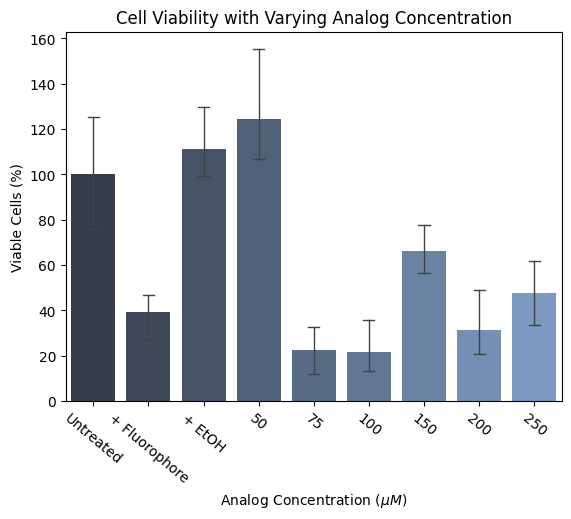

In [184]:
new_df = (cell_counts.iloc[:,selection].copy() * 100).reset_index()
df_melt = pd.melt(new_df, id_vars=['index'], value_vars=new_df.columns)
df_melt.columns= ["index", r"Analog Concentration ($\mu M$)", r"Viable Cells (%)"]
sns.barplot(data=df_melt, x=r"Analog Concentration ($\mu M$)", y=r"Viable Cells (%)", palette=sns.dark_palette("#8BF", n_colors=14)[2:13], ci=99, capsize=0.2, errwidth=1)
plt.title("Cell Viability with Varying Analog Concentration")
plt.xticks(rotation=-40)
plt.show()

In [186]:
cell_counts.describe()

,50,75,100,150,200,250,Untreated,+ EtOH,+ Fluorophore
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.246269,0.223881,0.216418,0.664179,0.313433,0.477612,1.000000,1.111940,0.395522
std,0.221211,0.120640,0.101595,0.107283,0.171479,0.148255,0.255045,0.178065,0.125172
min,1.044776,0.119403,0.119403,0.567164,0.208955,0.298507,0.716418,0.985075,0.208955
25%,1.111940,0.119403,0.164179,0.589552,0.208955,0.410448,0.850746,1.007463,0.388060
50%,1.194030,0.223881,0.194030,0.641791,0.238806,0.477612,0.985075,1.044776,0.447761
75%,1.328358,0.328358,0.246269,0.716418,0.343284,0.544776,1.134328,1.149254,0.455224
max,1.552239,0.328358,0.358209,0.805970,0.567164,0.656716,1.313433,1.373134,0.477612


In [292]:
def cleanup(img, norm = False):
    new_img = median_filter(img)
    new_img = new_img - np.percentile(new_img.flatten(), 5)
    new_img = np.max(np.stack([new_img, np.zeros_like(new_img)], axis=0), axis=0).astype(np.uint8)
    if norm:
        new_img = new_img / np.percentile(new_img.flatten(), 95) * 255
        new_img = np.min(np.stack([new_img, np.ones_like(new_img) * 255], axis=0), axis=0).astype(np.uint8)
    return new_img


In [119]:
im_file

'glyco/A1_DAPI.tiff'

In [136]:
def gamma_corr(r, gamma: int, L=256):
    return ((L-1) * np.power((r / (L-1)), gamma)).astype(np.uint8)

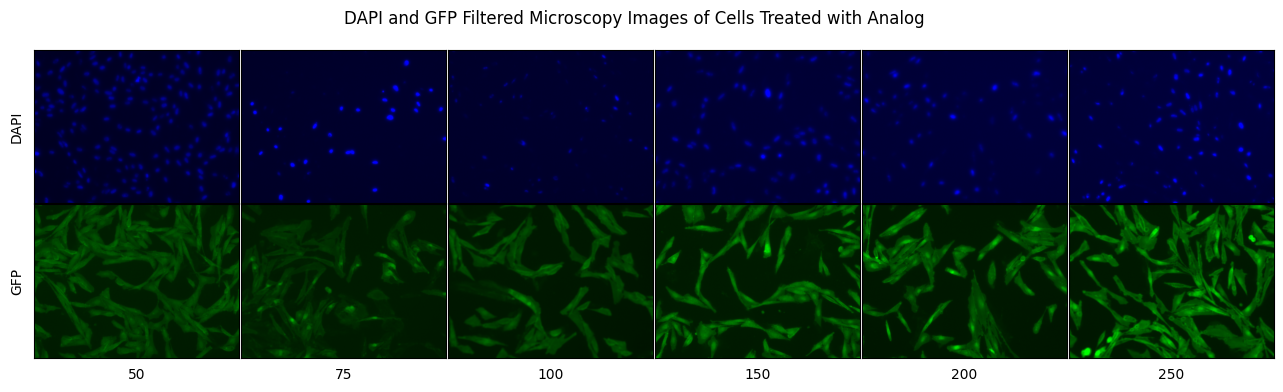

In [180]:
fig, ax = plt.subplots(nrows=2, ncols=6)
fig.set_size_inches(16, 4)
fig.suptitle("DAPI and GFP Filtered Microscopy Images of Cells Treated with Analog")
for i, im_file in enumerate(image_files[0:-3]):
    key = Path(im_file).name[0:2]
    dapi = cv2.imread("glyco/{}_DAPI.tiff".format(key), cv2.IMREAD_COLOR)
    gfp = cv2.imread("glyco/{}_GFP.tiff".format(key), cv2.IMREAD_COLOR)
    ax[0, i].imshow(dapi[...,::-1], vmin=0, vmax=255)
    ax[1, i].imshow(gfp, vmin=0, vmax=255)
    ax[0, i].get_xaxis().set_ticks([])
    ax[1, i].get_xaxis().set_ticks([])
    ax[0, i].get_yaxis().set_ticks([])
    ax[1, i].get_yaxis().set_ticks([])
    ax[1, i].xaxis.set_label_text(conditions[i])
ax[0, 0].yaxis.set_label_text("DAPI")
ax[1, 0].yaxis.set_label_text("GFP")
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("Experimental.png", bbox_inches="tight", transparent=True)
plt.show()


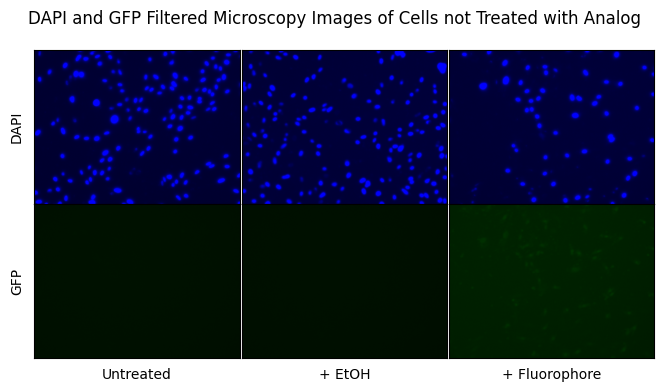

In [178]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(8, 4)
for i, im_file in enumerate(image_files[-3:]):
    key = Path(im_file).name[0:2]
    dapi = cv2.imread("glyco/{}_DAPI.tiff".format(key), cv2.IMREAD_COLOR)
    gfp = cv2.imread("glyco/{}_GFP.tiff".format(key), cv2.IMREAD_COLOR)

    ax[0, i].imshow(dapi[...,::-1], vmin=0, vmax=255)
    ax[1, i].imshow(gfp, vmin=0, vmax=255)

    ax[0, i].get_xaxis().set_ticks([])
    ax[1, i].get_xaxis().set_ticks([])
    ax[0, i].get_yaxis().set_ticks([])
    ax[1, i].get_yaxis().set_ticks([])
    ax[1, i].xaxis.set_label_text(conditions[i+6])
fig.subplots_adjust(wspace=0.01, hspace=0.00)
ax[0, 0].yaxis.set_label_text("DAPI")
ax[1, 0].yaxis.set_label_text("GFP")
fig.suptitle("DAPI and GFP Filtered Microscopy Images of Cells not Treated with Analog")
plt.savefig("Controls.png", bbox_inches="tight", transparent=True)
plt.show()

In [ ]:



# plt.figure(figsize=(10, 10))
# dapi = cv2.imread("GeneDelivery/A5_DAPI.jpg", cv2.IMREAD_GRAYSCALE)
# plt.imshow(dapi)
# plt.colorbar()

# th, img_thresh = cv2.threshold(dapi, 4, 15, cv2.THRESH_BINARY)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
# opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel, iterations=1)
# close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

# cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# minimum_area = 200
# average_cell_area = 650
# connected_cell_area = 800
# cells = 0
# for c in cnts:
#     area = cv2.contourArea(c)
#     if area > minimum_area:
#         cv2.drawContours(dapi, [c], -1, (36,255,12), 2)
#         if area > connected_cell_area:
#             cells += math.ceil(area / average_cell_area)
#         else:
#             cells += 1
# print('Cells: {}'.format(cells))
# plt.figure()
# plt.imshow(close)
# plt.show()
# plt.figure()
# plt.imshow(dapi)
# plt.show()